In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split

import chainer
import chainer.links as L
import chainer.functions as F
from chainer.training import extensions

import csv

In [2]:
# define class and function
class MultiLayerPerceptron(chainer.Chain):
    """Class of deep neural network(DNN) description
    
    Args:
        nodes(list of int):Nodes of network layers
        dropout(float):Dropout ratio
    """
    
    def __init__(self,nodes):
        super(MultiLayerPerceptron, self).__init__()
        self.nodes = nodes
        self.layers = len(self.nodes)
        for i in range(self.layers-1):
            self.add_link("l{}".format(i), L.Linear(self.nodes[i], self.nodes[i+1]))
            
    def __call__(self,x):
        """Return predictive values.
        
        Args:
            x([chainer]Variable):Input of DNN
        Returns:
            y([chainer]Variable):Output of DNN
        """
        y = self["l0"](x)
        for i in range(self.layers-2):
            h = F.relu(y)
            y = self["l{}".format(i+1)](h)
        return y
    
def train_test_tuple_dataset(x,y,test_ratio):
    """Make training & testing data set.

    Args:
        x([numpy]ndarray):Input series
        y([numpy]ndarray):Output series
        test_ratio(float):Test data ratio in (0,1)
    """
    x_train, x_test, y_train, y_test = train_test_split(x,y,
                                                        test_size = test_ratio,
                                                        random_state=True)
    print(y_test)
    print(type(y_test))
    train = chainer.datasets.TupleDataset(x_train, y_train)
    test = chainer.datasets.TupleDataset(x_test, y_test)
    return train,test

#高橋自作
def train_test_tuple_dataset2(x,y,test_data_size):
    """Make training & testing data set.

    Args:
        x([numpy]ndarray):Input series
        y([numpy]ndarray):Output series
        test_ratio(float):Test data ratio in (0,1)
    """
    #x_train, x_test, y_train, y_test = train_test_split(x,y,
    #                                                    test_size = test_ratio,
    #                                                    random_state=True)
    x_train=[]
    y_train=[]
    x_test=[]
    y_test=[]
    i=0
    for i in range(len(x)-test_data_size):
        x_train.append(x[i])
        y_train.append(y[i])
    for i in range(test_data_size):
        x_test.append(x[len(x)-test_data_size+i])
        y_test.append(y[len(y)-test_data_size+i])
   
    train = chainer.datasets.TupleDataset(np.array(x_train), np.array(y_train))
    test = chainer.datasets.TupleDataset(np.array(x_test), np.array(y_test))
    return train,test
    
def myplot(p,y,color='blue'):
    """Plot predict values and actual values.

    Args:
        p([numpy]ndarray):Predict values
        y([numpy]ndarray):Actual values
        color(str):Graph color name
    """
    y_ncol = y.shape[1]
    e = (p-y)/y*100
    means = np.average(e,axis=0)
    sds = np.std(e,axis = 0)
    fig, axes = plt.subplots(nrows=1,ncols=y_ncol,figsize=(3.5*y_ncol,2.5),sharex=True,sharey=True)
    for i in range(y_ncol):
        if y_ncol>1:
            ax = axes[i]
        else:
            ax = axes
        yimax = (1.05*max([p[:,i].max(),y[:,i].max()]))
        ax.grid(color = 'lightgray', linestyle='--')
        ax.scatter(p[:,i], y[:,i], color = color,
                  label="N:{0}\nmean: {1:.2f}%\nsd: {2:.2f}%".format(len(y), means[i],sds[i]))
        ax.plot([0, yimax], [0, yimax])
        ax.legend()
#高橋自作
def myplot(p,y,color='blue'):
    """Plot predict values and actual values.

    Args:
        p([numpy]ndarray):Predict values
        y([numpy]ndarray):Actual values
        color(str):Graph color name
    """
    y_ncol = y.shape[1]
    e = (p-y)/y*100
    means = np.average(e,axis=0)
    sds = np.std(e,axis = 0)
    fig, axes = plt.subplots(nrows=1,ncols=y_ncol,figsize=(3.5*y_ncol,2.5),sharex=True,sharey=True)
    for i in range(y_ncol):
        if y_ncol>1:
            ax = axes[i]
        else:
            ax = axes
        yimax = (1.05*max([p[:,i].max(),y[:,i].max()]))
        ax.grid(color = 'lightgray', linestyle='--')
        ax.scatter(p[:,i], y[:,i], color = color,
                  label="N:{0}\nmean: {1:.2f}%\nsd: {2:.2f}%".format(len(y), means[i],sds[i]))
        ax.plot([0, yimax], [0, yimax])
        ax.legend()

In [3]:
#define csv file
num_brand = 5406
data_csv_file = str(num_brand)+".csv"

#input columns' name
x_columns = ['Open']#,'diff']

#predict columns' name
y_columns = ['Close']

#network parameters
layer_number = 4
hidden_node_number = 100

#training conditions
io_normalization = False
train_data_number = 1769
epoch_number =100
batch_size = 100
test_data_size = 100
optimizer = chainer.optimizers.Adam()
mylossfun = F.mean_squared_error
myaccfun = F.r2_score

gpu_device = -1 #IF you use gpu, set gpu number(e.g. gpu_device = 0)

#make data set
df = pd.read_csv(data_csv_file, sep=',')

xs = df[x_columns]
ys = df[y_columns]

if io_normalization:
    from sklearn.preprocessing import StandardScaler
    x_scaler = StandardScaler()
    y_scaler = StandardScaler()
    xs_f = x_scaler.fit_transform(xs).astype(np.float32)
    ys_f = y_scaler.fit_transform(ys).astype(np.float32)
else:
    x_scaler = None
    y_scaler = None
    xs_f = xs.values.astype(np.float32)
    ys_f = ys.values.astype(np.float32)
    
assert train_data_number < df.shape[0]
test_ratio = 1-train_data_number/df.shape[0]
train, test = train_test_tuple_dataset2(xs_f, ys_f, test_data_size)
#train, test = train_test_tuple_dataset(xs_f, ys_f, test_ratio) #原文の関数


nodes = [hidden_node_number]*layer_number
nodes[0] = len(x_columns)
nodes[-1] = len(y_columns)

In [4]:
#define multilayer perceptron network
model = L.Classifier(MultiLayerPerceptron(nodes),
                    lossfun = mylossfun,
                    accfun = myaccfun)

#setup training enviroments
optimizer.setup(model)
train_iter = chainer.iterators.SerialIterator(train, batch_size)
test_iter = chainer.iterators.SerialIterator(test, batch_size, 
                                             repeat=False, shuffle = False)
updater = chainer.training.StandardUpdater(train_iter, optimizer, device = gpu_device)
trainer = chainer.training.Trainer(updater, (epoch_number, 'epoch'))

trainer.extend(extensions.Evaluator(test_iter, model, device = gpu_device))
trainer.extend(extensions.LogReport())
trainer.extend(extensions.PrintReport(['epoch',
                                      'iteration',
                                      'elapsed_time',
                                      'main/loss',
                                      'validation/main/loss',
                                      'main/accuracy',
                                      'validation/main/accuracy']))
                                      
#exec.training
trainer.run()

if gpu_device >= 0:
    model.to_cpu()


epoch       iteration   elapsed_time  main/loss   validation/main/loss  main/accuracy  validation/main/accuracy
1           17          0.0649733     53283       36498.3               0.591305       -6.92341                  
2           34          0.131739      3543.45     1672.87               0.971781       0.636837                  
3           51          0.19825       1081.46     4725.67               0.99132        -0.0258927                
4           67          0.281631      343.949     862.792               0.99744        0.812697                  
5           84          0.346677      95.2241     577.248               0.999241       0.874685                  
6           101         0.414913      64.4521     513.567               0.999487       0.88851                   
7           117         0.473814      72.0052     500.509               0.999412       0.891345                  
8           134         0.555774      64.8343     454.427               0.999476       0.9

72          1203        5.81678       75.0219     495.471               0.999401       0.892438                  
73          1220        5.94096       67.2184     463.578               0.999482       0.899362                  
74          1236        6.04346       61.1676     497.507               0.999489       0.891996                  
75          1253        6.12481       66.5354     470.213               0.999443       0.897922                  
76          1270        6.25475       69.5914     457.633               0.999438       0.900653                  
77          1286        6.36106       66.3118     538.724               0.999468       0.883049                  
78          1303        6.44099       65.8778     476.57                0.999478       0.896542                  
79          1320        6.53812       62.7185     481.245               0.999498       0.895527                  
80          1336        6.67222       83.1381     633.246               0.999333       0

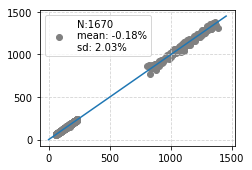

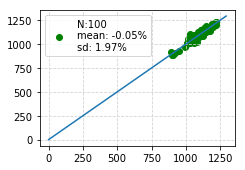

In [5]:
def myplot_aux(model, tuple_dataset, y_scaler = None):
    x = np.array([_x for _x in np.array(tuple_dataset)[:,0]])
    t = np.array([_t for _t in np.array(tuple_dataset)[:,1]])
    
    y = model(x).data
    if y_scaler is not None:
        t = y_scaler.inverse_transform(t)
        y = y_scaler.inverse_transform(y)
    return t,x, y
model.predictor
t,x, y = myplot_aux(model.predictor, train, y_scaler)
myplot(t, y, color = 'gray')
t,x, y = myplot_aux(model.predictor, test, y_scaler)
myplot(t, y, color='green')

try:
    y_sch = df[y_columns].values
    p_sch = df[[col + 'sch' for col in y_columns]].values
    myplot(y_sch, p_sch)
except:
    pass

plt.show()

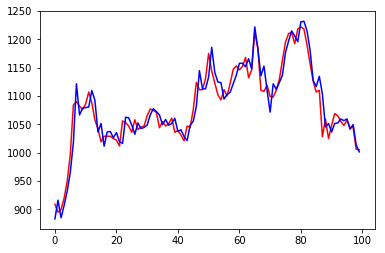

[ 0.13841248]
[array([ 0.13807678], dtype=float32), array([ 0.13841248], dtype=float32), array([ 0.1381073], dtype=float32), array([ 0.13834381], dtype=float32), array([ 0.13859558], dtype=float32), array([ 0.13889313], dtype=float32), array([ 0.13934326], dtype=float32), array([ 0.1401062], dtype=float32), array([ 0.13973999], dtype=float32), array([ 0.13980865], dtype=float32), array([ 0.13980865], dtype=float32), array([ 0.13980865], dtype=float32), array([ 0.14001465], dtype=float32), array([ 0.13991547], dtype=float32), array([ 0.13948822], dtype=float32), array([ 0.13960266], dtype=float32), array([ 0.1392746], dtype=float32), array([ 0.13948822], dtype=float32), array([ 0.13949585], dtype=float32), array([ 0.13942719], dtype=float32), array([ 0.13948822], dtype=float32), array([ 0.13934326], dtype=float32), array([ 0.13932037], dtype=float32), array([ 0.13968658], dtype=float32), array([ 0.1396637], dtype=float32), array([ 0.13957214], dtype=float32), array([ 0.13946533], dtype=

In [17]:
csvFile = open(str(num_brand)+"_result.csv",'wt',newline ='',encoding="shift_jis")
writer=csv.writer(csvFile)
writer.writerow(['num_brand=',num_brand])

s=[]
a=[x for x in range(len(t))]

plt.plot(a,t,color='red')
plt.plot(a,y,color='blue')

#tが実績、yがﾓﾃﾞﾙ予測値
updown_t=[]
updown_y=[]
score = 0

plt.show()

for i in range(len(x)):
    if x[i,0]<t[i]:
        updown_t.append(1)
    else:
        updown_t.append(-1)
    
    if x[i,0]<y[i]:
        updown_y.append(1)
    else:
        updown_y.append(-1)
    
    if updown_t[i] == updown_y[i]:
        score = score +1
    else:
        pass
    
    s.append(y[i]/x[i,0]*100-100)


print(s[1])
print(s)
score = score/len(x)
print(score)
writer.writerow(['score=',score])
writer.writerow(['stock buying and selling simulation'])

Fund = 1000000 #[円]
Investment = 0 #投資額/日
stock_num = 0 #購入株数/日
charge = 90 #手数料
ratio_inv = 0.3

#株売買ｼﾐｭﾚｰｼｮﾝ
for i in range(len(x)):
    if updown_y[i] ==1:
        Investment = ratio_inv*Fund
        Fund = Fund - Investment
        stock_num = Investment/x[i,0]
        Fund = Fund + stock_num*t[i]-charge
    if updown_y[i] ==-1:
        Investment = ratio_inv*Fund
        Fund = Fund + Investment
        stock_num = Investment/x[i,0]
        Fund = Fund - stock_num*t[i]-charge
    
    writer.writerow(['Day',i,Fund[0]/10000])
    #print(Fund)

#結果をcsv形式で保存

csvFile.close()